<h1><center>K-Means Clustering Algorithms</center></h1>

<h2><center>Ensun Pak</center></h2>

Python code for my implementation of Kmeans and Kmeans++ algorithm.


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.utils import shuffle

import scipy.cluster.hierarchy as shc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_style("darkgrid")
pd.set_option('display.max_rows', 500)

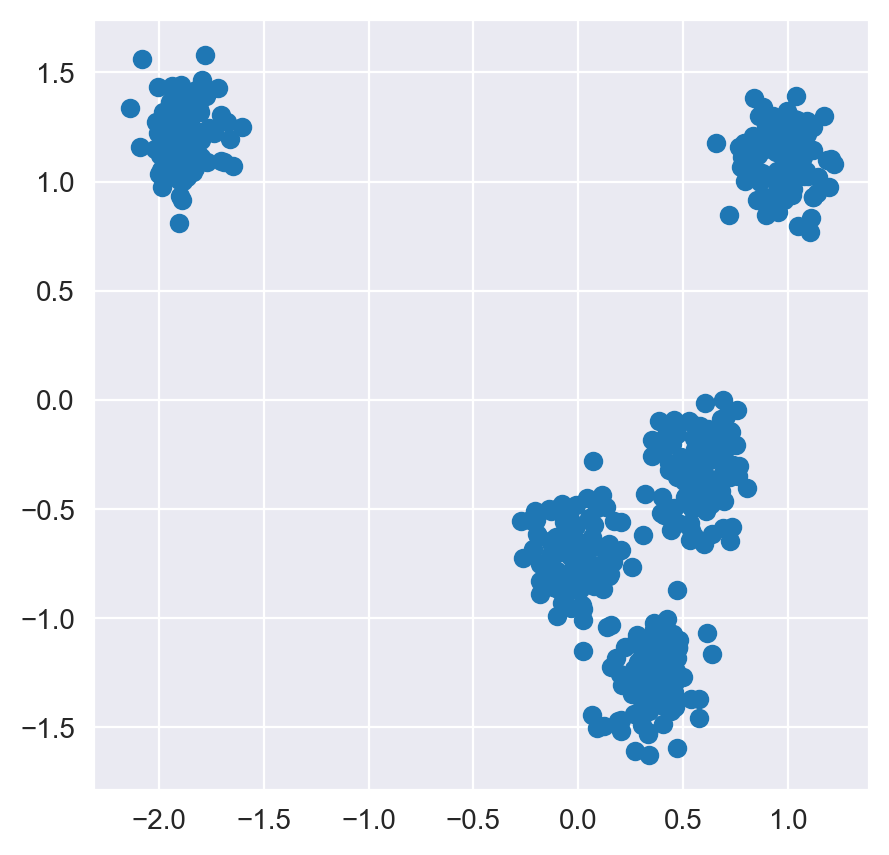

In [21]:
# Create toy dataset
centers = 5
x_train, true_labels = make_blobs(n_samples=500, centers=centers, cluster_std=0.65)

x_train = StandardScaler().fit_transform(x_train)

plt.figure(figsize=(5, 5))
plt.scatter([x[0] for x in x_train] , [x[1] for x in x_train])
plt.set_cmap("Set1")
plt.show()

In [22]:
# Implementation of basic Kmeans algorithm
def kmeans(X, k, max_iter=30, tolerance=1e-2):
    i = 0
    curr_centroids, prev_centroids = 0, 0
    while i <= max_iter: 
        if i == 0:
            # Randomly select k points from X as starting centroids
            rand = np.random.choice(len(X), k, replace=False)
            centroids = X[rand]

            # For each element in X, calculate their distance from each
            # starting centroid and store the argmin in a list.
            labels = []
            for elem in X:
                dist_to_centroid = []
                for centroid in centroids:
                    distance = np.abs(np.linalg.norm(centroid - elem))
                    dist_to_centroid.append(distance)
                labels.append(np.argmin(dist_to_centroid)) # assign to cluster
            
            # Store the mean of current set of centroids for comparison to
            # next generation. 
            prev_centroids = centroids
        elif i > 0:
            # Recalculate the centroid from first generation clusters
            centroids = []
            for cluster in range(k):
                temp_cluster = []
                for idx, elem in enumerate(labels):
                    if elem == cluster:
                        temp_cluster.append(X[idx])
                centroids.append(np.mean(temp_cluster, axis=0))

            curr_centroids = centroids

            # Recalculate for each element in X, their distance from each
            # new generation of centroids and store the argmin in a list.
            labels = []
            for elem in X:
                dist_to_centroid = []
                for centroid in centroids:
                    distance = np.abs(np.linalg.norm(centroid - elem))
                    dist_to_centroid.append(distance)
                labels.append(np.argmin(dist_to_centroid))
        
        # Stop the loop if tolerance has been met.
        if curr_centroids != 0:
            if np.abs(np.linalg.norm(curr_centroids)\
                - np.linalg.norm(prev_centroids)) < tolerance:
                break

        i += 1
        prev_centroids = centroids

    return centroids, labels

In [23]:
# Implementation of KMeans++ algorithm.
def kmeanspp(X, k, max_iter=30, tolerance=1e-2):
    # Procedure to get k centroids based on KMeans++ algorithm.
    curr_centroids, prev_centroids = 0, 0
    centroids = []
    for j in range(k):
        if j == 0:
            rand = np.random.choice(len(X), 1, replace=False)
            centroids.append(X[rand])
        elif j > 0:
            min_distance = []
            for elem in X:
                dist_to_centroids = []
                for c in centroids:
                    distance = np.linalg.norm(c - elem)
                    dist_to_centroids.append(distance)
                min_distance.append(np.min(dist_to_centroids))
            centroids.append(X[np.argmax(min_distance)])

    # Perform normal kmeans clustering with the centroids found.
    i = 0
    while i <= max_iter: 
        if i == 0:
            # For each element in X, calculate their distance from each
            # starting centroid and store the argmin in a list.
            labels = []
            for elem in X:
                dist_to_centroid = []
                for centroid in centroids:
                    distance = np.abs(np.linalg.norm(centroid - elem))
                    dist_to_centroid.append(distance)
                labels.append(np.argmin(dist_to_centroid)) # assign to cluster

            curr_centroids = centroids
        elif i > 0:
            # Recalculate the centroid from first generation clusters
            centroids = []
            for cluster in range(k):
                temp_cluster = []
                for idx, elem in enumerate(labels):
                    if elem == cluster:
                        temp_cluster.append(X[idx])
                centroids.append(np.mean(temp_cluster, axis=0))

            curr_centroids = centroids

            # Recalculate for each element in X, their distance from each
            # new generation of centroids and store the argmin in a list.
            labels = []
            for elem in X:
                dist_to_centroid = []
                for centroid in centroids:
                    distance = np.abs(np.linalg.norm(centroid - elem))
                    dist_to_centroid.append(distance)
                labels.append(np.argmin(dist_to_centroid))

        # Stop the loop if tolerance has been met.
        if curr_centroids != 0:
            if np.abs(np.linalg.norm(curr_centroids)\
                - np.linalg.norm(prev_centroids)).all() < tolerance:
                break

        i += 1
        prev_centroids = curr_centroids

    return centroids, labels

### 1. Introduction to K-means Clustering

This article will introduce the concept of the K-means clustering machine learning algorithm and also show some applications of this technique.

#### 1-1. What is K-means Clustering?

K-means clustering, or Lloyd's algorithm, is an unsupervised machine learning algorithm that aims to group similar data into clusters. In machine learning context, an unsupervised algorithm works without a target variable and contains only independent variables. It is one of the simplier machine leaarning algorithms available and is widely used. For example, K-means can be used in a product management setting. Imagine that we have some customer data, and we use K-means to segment those data into groups allowing us to discover similar customer profiles. The algorithm can also be applied to image compression. In certain fields, K-means can also be employed as an anomaly detection tool. It is able to isolate out single outliers or a small cluster of outliers from the main data cloud.

There are many different variants of K-means clustering algorithms available, each with their pros and cons. In this article, we will start by introducing two of the most common K-means algorithms, which is standard K-means and K-means++.

#### 1-2. What is the K-means algorithm?

The standard K-means algorithm is simple and straightforward to understand. The algorithm is as follows:

1. Define the number of clusters.
2. Randomly assign the clusters to the data points in the data.
3. Assign the data point to the centroid that it is closest to in distance.
4. Find the next iteration of clusters by calculating the centroid (or average) of each new cluster.
5. Repeat step 3 and 4 until the centroids of the clusters no longer change.

There are limitations to the standard K-means algorithm in that it is sensitive to the starting point of the centroids. If a centroid is initialized at a very distant point in the data cloud, it may end up with no data points associated with it. This in turn will cause some clusters to be grouped into one centroid instead. In addition to that, some centroids may also be initialized within the same cluster of data thus resulting in poor clustering[3].

To overcome the potential problems that come with the standard K-means algorithm, the K-means++ algorithm can be used. The difference between the two algorithm lies in the way K-means++ initializes the centroids. The rest of the clustering steps are exactly the same. K-means++  has the following algorithm:

1. Define the number of clusters.
2. Randomly assign the first of the clusters to a data point in the data cloud.
3. Select the next centroid from the data points such that the distance from the current centroids are maximized.
4. Repeat step 3 until the remaining centroids have been sampled.
5. Assign the data point to the centroid that it is closest to in distance.
6. Find the next iteration of clusters by calculating the centroid (or average) of each new cluster.
7. Repeat step 5 and 6 until the centroids of the clusters no longer change.

#### 1-3. K-means and K-means++ in action

We first generate a toy dataset to exhibit how the K-means algorithm works. The distribution of the data can be visualized in the following scatter plot.

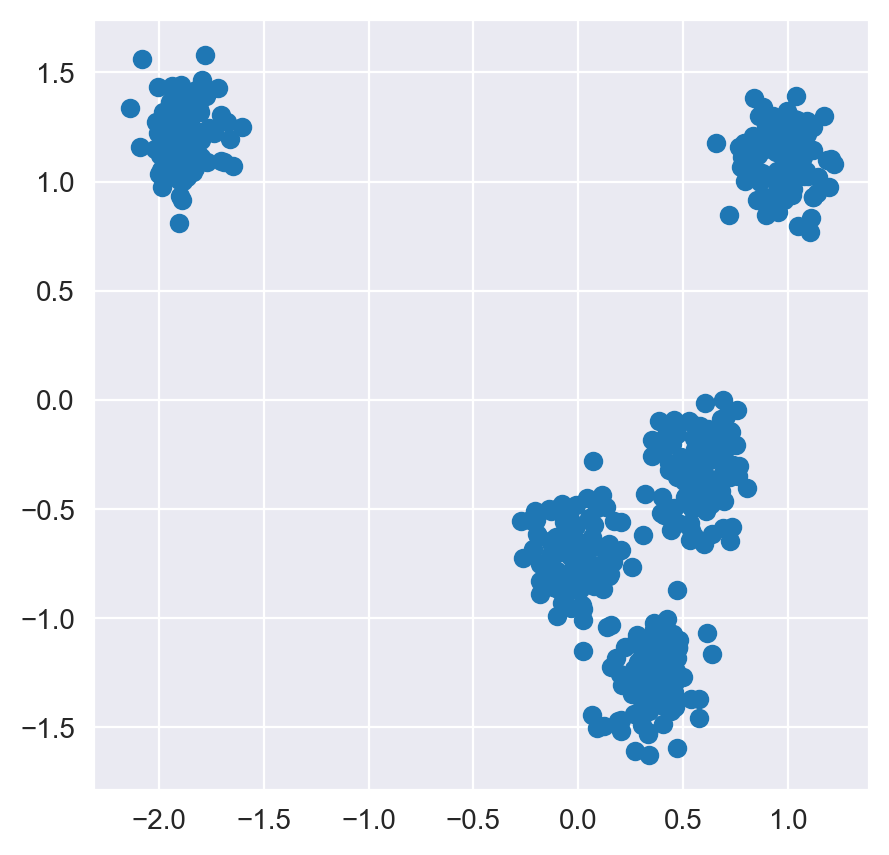

In [24]:
# Construct scatter plot of toy data.
plt.figure(figsize=(5, 5))
plt.scatter([x[0] for x in x_train] , [x[1] for x in x_train])
plt.set_cmap("Set1")
plt.show()

Now we will first execute the code that implements the standard K-means algoritm to cluster the toy data into five clusters.

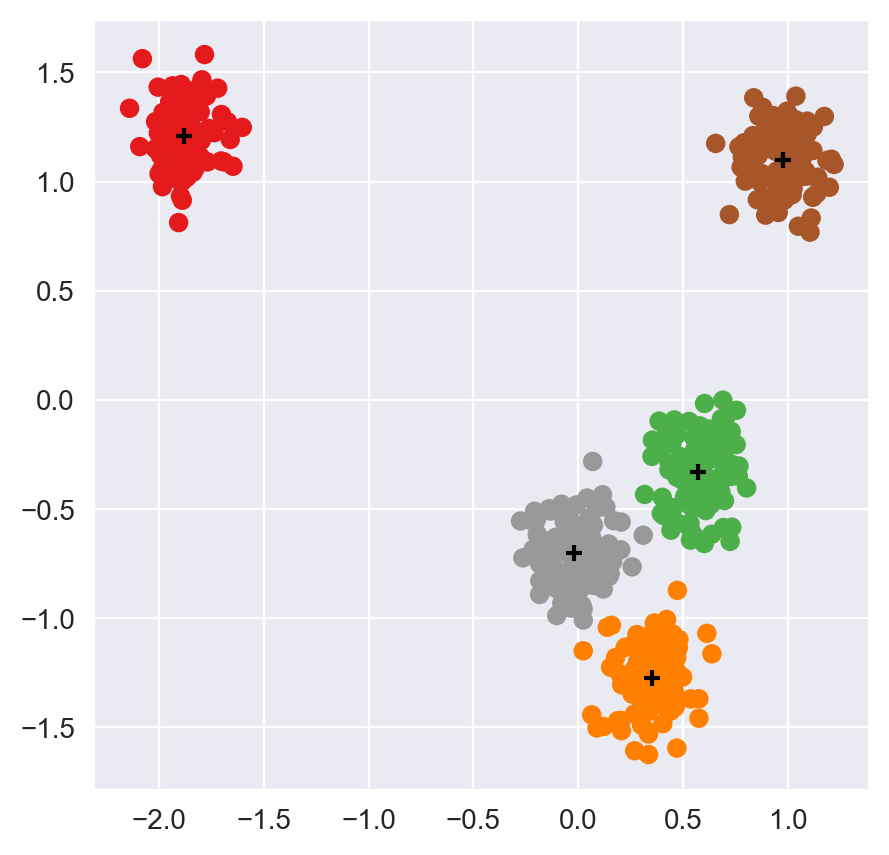

In [26]:
# Execute the code for standard K-means on 5 clusters.
centroids, labels = kmeans(x_train, 5)

# Construct plot of the K-means clustering.
plt.figure(figsize=(5, 5))
plt.scatter([x[0] for x in x_train] , [x[1] for x in x_train], c=labels)
plt.scatter([x[0] for x in np.array(centroids)], [x[1] for x in np.array(centroids)], 
            marker='+', c='black') # Plot centroids
plt.set_cmap("Set1")
plt.show()

As you can see, the algorithm has successfully clustered the data points into five distinct clusters. What happens when we try to cluster the same dataset into four clusters instead?

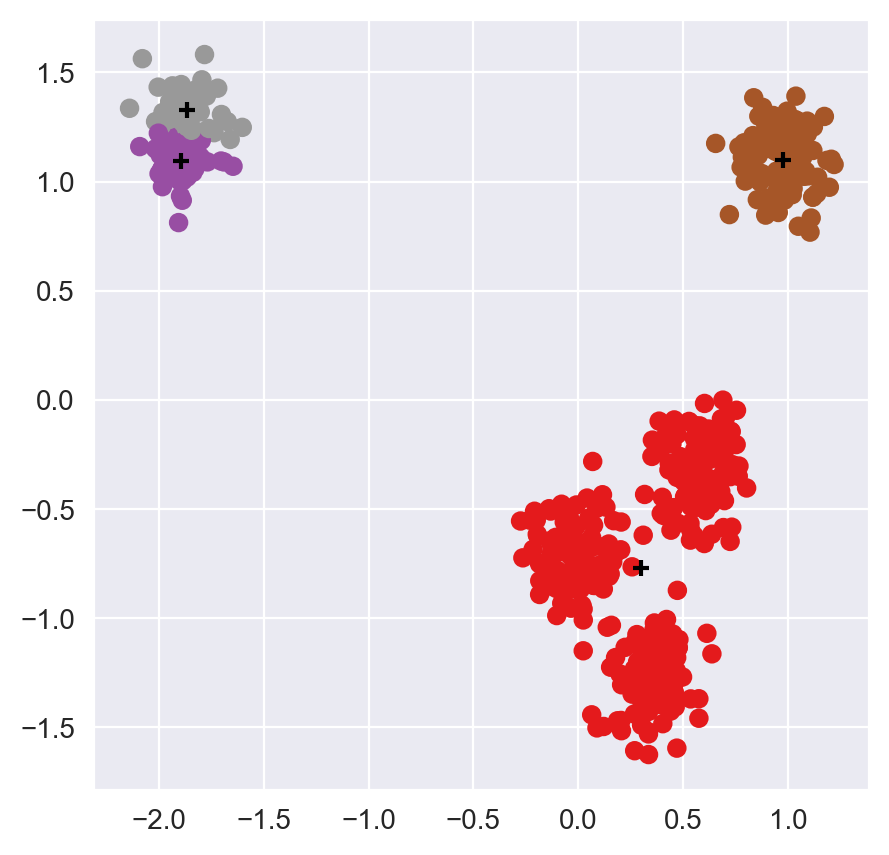

In [27]:
# Execute the code for standard K-means on 4 clusters.
centroids, labels = kmeans(x_train, 4)

# Construct plot of the K-means clustering.
plt.figure(figsize=(5, 5))
plt.scatter([x[0] for x in x_train] , [x[1] for x in x_train], c=labels)
plt.scatter([x[0] for x in np.array(centroids)], [x[1] for x in np.array(centroids)],
            marker='+', c='black') # Plot centroids
plt.set_cmap("Set1")
plt.show()

The algorithm did a pretty good job of clustering the data into four groups. But sometimes, due to the layout on the data, the initialization of the centroids may lead to poor clustering results. This is more evident in larger datasets. Consider the next dataset which has 1,000 samples compared to the first dataset which has 500.

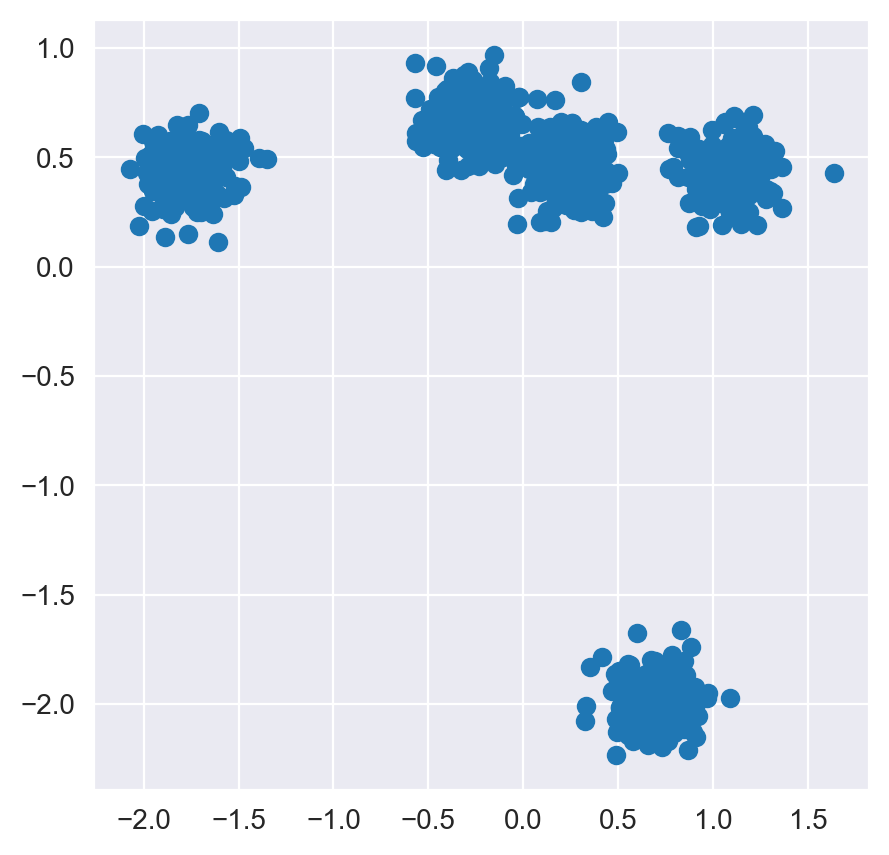

In [43]:
centers = 5
x_train2, true_labels2 = make_blobs(n_samples=1000, centers=centers, cluster_std=0.65)

x_train2 = StandardScaler().fit_transform(x_train2)

plt.figure(figsize=(5, 5))
plt.scatter([x[0] for x in x_train2] , [x[1] for x in x_train2])
plt.set_cmap("Set1")
plt.show()

Applying the standard K-means algorithm to assign the data into four clusters this time gives us poor clustering results. The cluster of data above has been clustered into one centroid, and the remaining four clusters share the data cluster below. What about the K-means++ algorithm? We will try that on this dataset to see if the clustering result will be better.

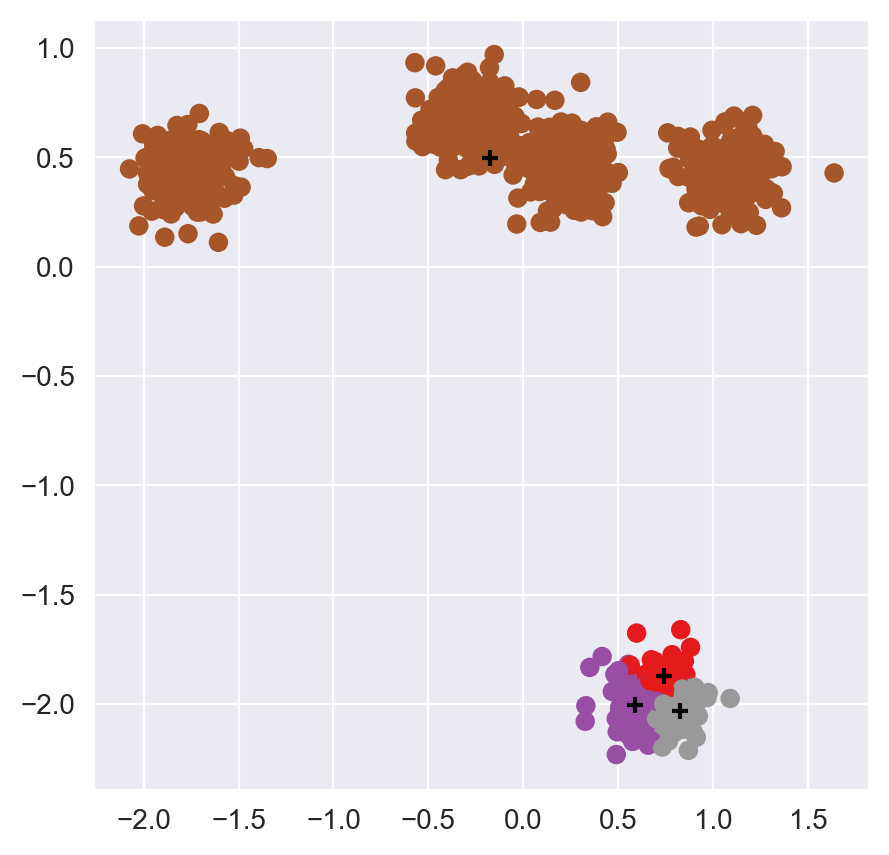

In [51]:
# Execute the code for standard K-means on 4 clusters.
centroids, labels = kmeans(x_train2, 4)

# Construct plot of the K-means clustering.
plt.figure(figsize=(5, 5))
plt.scatter([x[0] for x in x_train2] , [x[1] for x in x_train2], c=labels)
plt.scatter([x[0] for x in np.array(centroids)], [x[1] for x in np.array(centroids)],
            marker='+', c='black') # Plot centroids
plt.set_cmap("Set1")
plt.show()

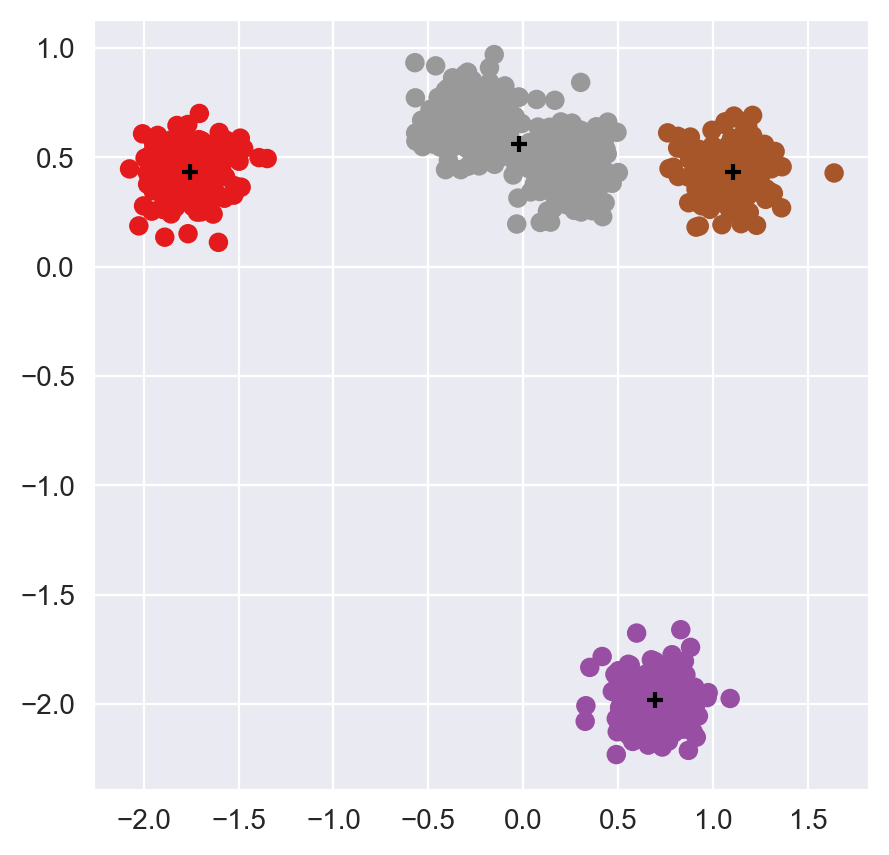

In [53]:
# Execute the code for K-means++ on 4 clusters.
centroids, labels = kmeanspp(x_train2, 4)

# Construct plot of the K-means clustering.
plt.figure(figsize=(5, 5))
plt.scatter([x[0] for x in x_train2] , [x[1] for x in x_train2], c=labels)
plt.scatter([x[0] for x in np.array(centroids)], [x[1] for x in np.array(centroids)],
            marker='+', c='black')
plt.set_cmap("Set1")
plt.show()

From the diagram, the K-means++ algorithm indeed performed the clustering of the dataset much better than the standard K-means algorithm. In the toy dataset created for this article, the data were clustered very apparently so it was easy to determine how many clusters would best fit the data. What happens if the data becomes too scattered instead? Are there ways to determine the best number of clusters to use with K-means clustering?

#### 1-4. Hyperparameter tuning - What is the optimum number of clusters to use for my data?

There are many methods available to determine the optimum number of clusters to use for a given dataset. In this article, the Elbow method[4] and Silhouette method will be discussed. The Elbow method depends on the clustering error, or "within cluster sum squares" (WCSS), defined as the sum of the squared distance between each data point assigned to the centroid and the centroid itself. The algorithm for the Elbow method is as follows:
1. Fit a K-means model on the dataset.
2. Calculate the within cluster sum of squares (WCSS) for this model.
3. Repeat steps 1 and 2 for N number of K-means models.
4. Construct a plot of the models' WCSS against model clusters.
5. Analyze the plot and locate the elbow point for optimum number of clusters.

The Silhouette method will show us "Silhouette scores" which is a "measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation)"[5]. The algorithm for the Silhouette method is as follows:
1. Fit a K-means model on the dataset.
2. Calculate the Silhouette score for this model.
3. Repeat steps 1 and 2 for N number of K-means models.
4. Construct a plot of the models' Silhouette scores against model clusters.
5. Analyze the plot and locate the maximum score for optimum number of clusters.

By using the K-means function in the Scikit-learn package, both the Elbow and Silhouette methods will be demonstrated here.

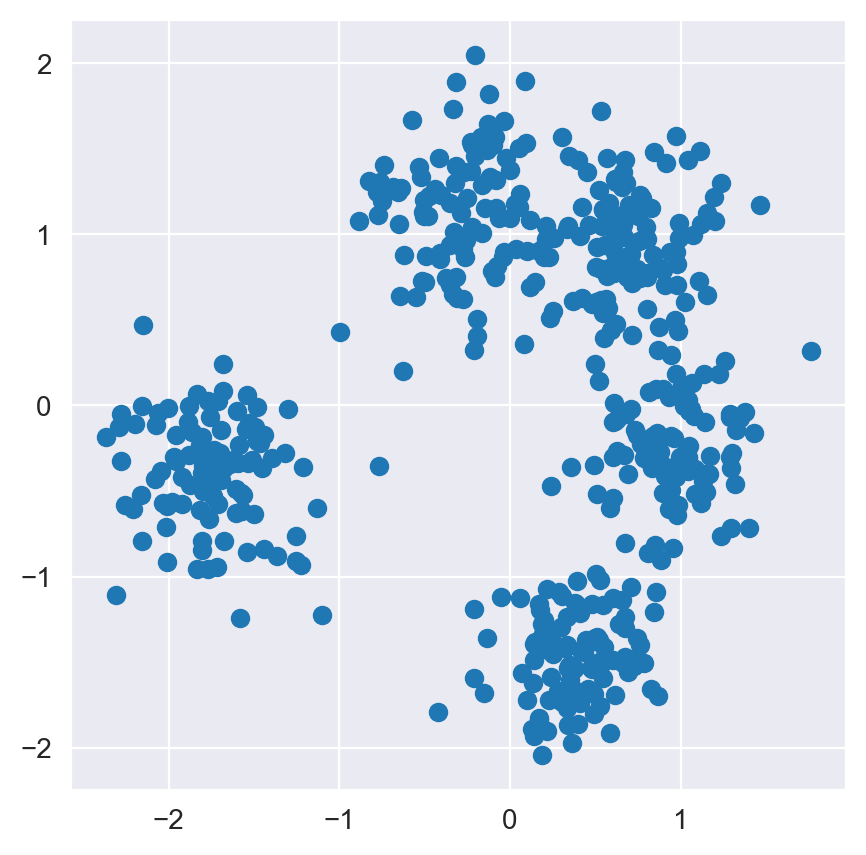

In [89]:
# Create toy dataset
centers = 5
x_train3, true_labels = make_blobs(n_samples=500, centers=5)

x_train3 = StandardScaler().fit_transform(x_train3)

plt.figure(figsize=(5, 5))
plt.scatter([x[0] for x in x_train3] , [x[1] for x in x_train3])
plt.set_cmap("Set1")
plt.show()

In [108]:
# Execute Sklearn's KMeans function on the dataset to get 10 simulations
wcss = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, init='k-means++')
    kmeans.fit(x_train3)
    wcss.append(kmeans.inertia_)

# Construct Elbow plot
plt.figure(figsize=(7, 4))
plt.plot(range(1, 11), wcss, 'o-')
plt.title('Elbow Plot')
plt.ylabel('WCSS')
plt.xlabel('Number of clusters')
plt.show()

From the Elbow plot, we find the point on the line where the trend shifts abrubtly, the shape we are looking for is similar to a person's elbow, which is why this method is called the Elbow method. By visually inspecting the plot, 3 clusters seem to be the optimal. Let's refit our KMeans model with 3 clusters and then visuallize the clustering to review the outcome.

While the concept of the Elbow method is simple to use, as it requires visual inspection to locate the "elbow" on the plot, this method is more suceptible to human judgment and implies variance in the interpretation from one person to the next. The Silhouette method is more quantitative. It will return a score between -1 and 1 for each cluster. A score towards 1 is the best indicating that the cluster is compact and it is far away from the other clusters. A score towards -1 is the worst possible, and a score around 0 denotes overlapping of clusters[5]. We will use the Silhouette method to compare the results on finding the optimum clusters to use for our dataset based on 9 simulations. For this method, a K-means cluster simulation of 1 is not possible as minimally two clusters are required in the algorithm. The maximum Sillhouette score shall be the optimum cluster size.

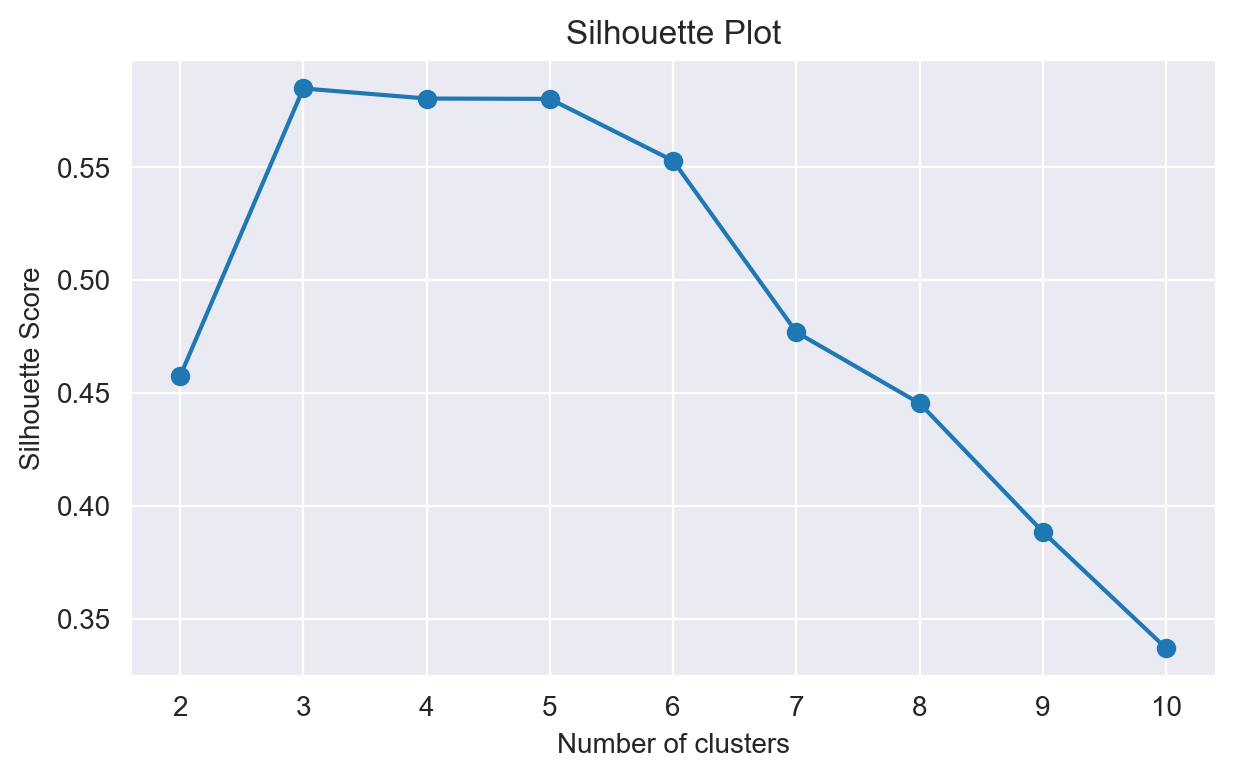

In [141]:
# Execute Sklearn's KMeans function on the dataset to get 9 simulations
silhouette = []
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, init='k-means++')
    kmeans.fit(x_train3)
    silhouette.append(silhouette_score(x_train3, kmeans.labels_))

# Construct Silhouette plot
plt.figure(figsize=(7, 4))
plt.plot(range(2, 11), silhouette, 'o-')
plt.title('Silhouette Plot')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of clusters')
plt.show()

By visually inspecting the Silhouette plot, the cluster size of three is consistent with what the Elbow method produced earlier. Often it is a good idea to use both methods just to be more confident in selecting the optimal number of clusters to fit your data.

### 2. Other clustering algorithms

#### 2-1. Spectral Clustering

In the previous section, we discussed the algorithm and implementation of standard K-means and its variation, the K-means++. It is a relatively simple to use algorithm among other machine learning algorithms available. However, like all algorithms, it does have limitations. On datasets that are typically convex in shape, the standard K-means algorithm, which is Euclidean distance based, will most probably not work well in clustering the data.

We turn to other more sophisticated algorithms to solve this problem. Spectral clustering is one such clustering algorithm which can detect connectivity in the data, and then cluster them accordingly. This algorithm is named as such because the technique relies on the spectrum (hence spectral) or eigenvalues of the similarity matrix of the data to perform dimensionality reduction before clustering the same data in fewer dimensions[7]. The algorithm for Spectral clustering[8] is as follows:

1. Project the data on a $R^n$ matrix.
2. Define an affinity matrix A by using Gaussian Kernel K, or construct an adjacency matrix.
3. Construct the Graph Laplacian from matrix A.
4. Find the eigenvalues of the Graph Laplacian.
5. Select the k eigenvectors that correspond to the lowest k eigenvalues to obtain the k-dimension subspace.
6. Form clusters in this subspace using K-means algorithm. 

In the sections to follow in this article, we will contrast the standard K-means clustering and the Spectral clustering algorithms on a toy data with convex shape.

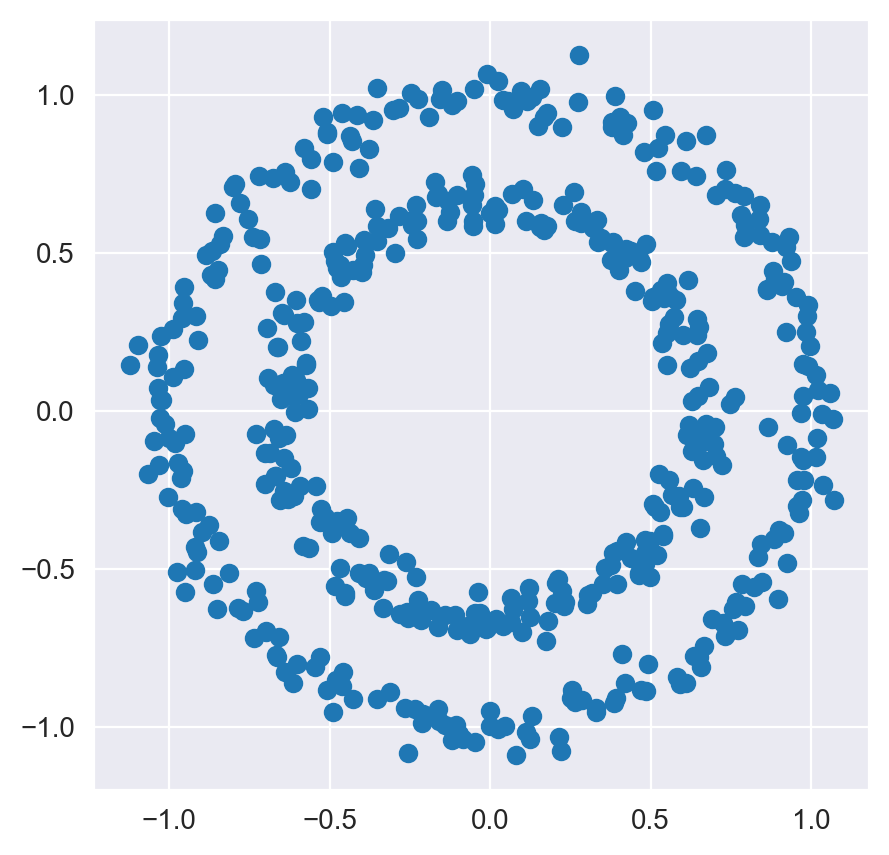

In [170]:
# Create toy data
X, y = make_circles(n_samples=500, factor=0.65, noise=0.05)
plt.figure(figsize=(5, 5))
plt.scatter([i[1] for i in X], [i[0] for i in X])
plt.show()

We will now perform the standard K-means clustering algorithm on this dataset.

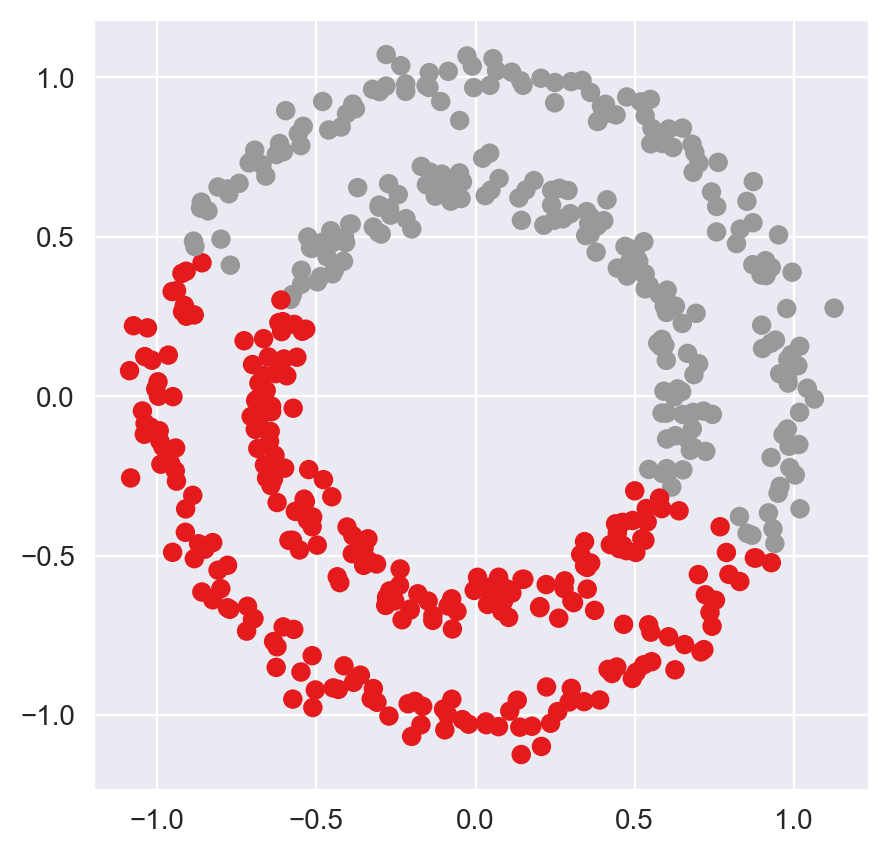

In [177]:
# Execute the code for K-means on 2 clusters.
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Construct the scatter plot.
plt.figure(figsize=(5, 5))
plt.scatter([i[0] for i in X] , [i[1] for i in X], c=y_kmeans)
plt.set_cmap("Set1")
plt.show()

As we can see from the plot, the K-means algorithm did not cluster the data correctly. Now let's try applying the Spectral clustering algorithm on the same dataset and observe the outcome.

In [182]:
spectral = SpectralClustering(n_clusters=2, affinity ='nearest_neighbors')
y_kmeans = spectral.fit_predict(X)

# Construct the scatter plot.
plt.figure(figsize=(5, 5))
plt.scatter([i[0] for i in X] , [i[1] for i in X], c=y_kmeans)
plt.set_cmap("Set1")
plt.show()

From the plot, we can observe that the data has been properly clustered using the Spectral clustering algorithm. From this, awareness of other clustering algorithms will help us to decide which algorithm to employ for a specific problem that we are actually trying to solve.

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

#### 2-2. Hierarchical Clustering

Hierarchical clustering is another variant of the clustering algorithm. This algorithm aims to cluster data points from a hierarchy approach instead. Usually there are two methods used in hierarchical clustering which is agglomerative or divisive. Agglormerative hierarchical clustering solves the problem from a bottom-up approach, while divisive hierarchical clustering follows a top-down approach. In this article, agglomerative hierarchical clustering will be discussed[11]. The results of the algorithm is usually reviewed through a dendogram plot. The key difference between hierarchical clustering and Kmeans clustering is that we need to figure out the number of clusters in Kmeans where as in hierarchical clustering, we do not need to. The use case for this clustering algorithm is for clustering data into a natural hierarchy[12]. Here is the algorithm for carrying out Hierarchical clustering[14]:

1. Make each data point a single cluster.
2. Take the two closest data points and make them a cluster.
3. Take the two closest clusters and make them a cluster.
4. Repeat step 3 until there is only one cluster left.

Heavily inspired by this blog post[13] about hierarchy clustering, let's see this clustering algorithm in action to solve a customer segmentation problem for a wholesale business. We wish to analyze and find out what are the different customer segments who have purchased frozen and fresh groceries.

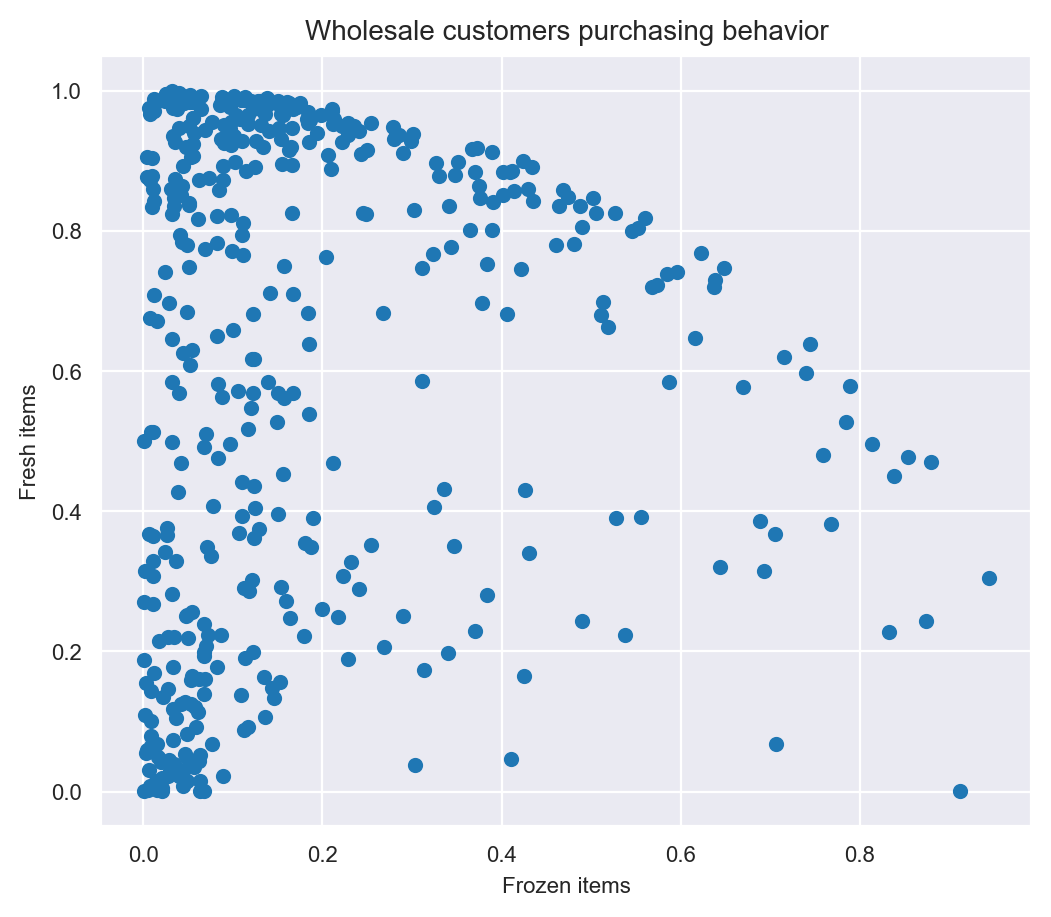

In [471]:
# Load the grocery dataset.
grocery = pd.read_csv('Wholesale customers data.csv')

# Scale the data to make the evaluation of distance to cluster fair.
grocery_scaled = normalize(grocery)
grocery_scaled = pd.DataFrame(grocery_scaled, columns=grocery.columns)

plt.figure(figsize=(6, 5))
plt.title('Wholesale customers purchasing behavior', fontsize=10)
plt.ylabel('Fresh items', fontsize=8)
plt.xlabel('Frozen items', fontsize=8)
plt.tick_params(labelsize=8)
plt.scatter(grocery_scaled['Frozen'], grocery_scaled['Fresh'], s=20)
plt.show()

From the scatter plot, it does not seem easy to tell where the customer segments are in the interaction between fresh and frozen item purchases. Next, we will take a look at the dendograms from the clustering technique.

In [465]:
plt.figure(figsize=(6, 5))  
plt.title("Dendrograms", fontsize=10)
plt.ylabel('Euclidean distance', fontsize=8)
dend = shc.dendrogram(shc.linkage(grocery_scaled, method='ward'))

This diagram is called a dendogram and it shows us the clusters that form from the bottom. The y-axis of the diagram shows the distance of eacb cluster from the others in the data cloud. From here, we can see that there could be two to eight clusters that are meaningful in the analysis. Let's examine the results if we were to consider two and four clusters in this example, we would draw a horizontal line across the dendogram to get the clusters we want. The red dashed line will result in forming two clusters, and the blue dashed line will return 4 clusters.

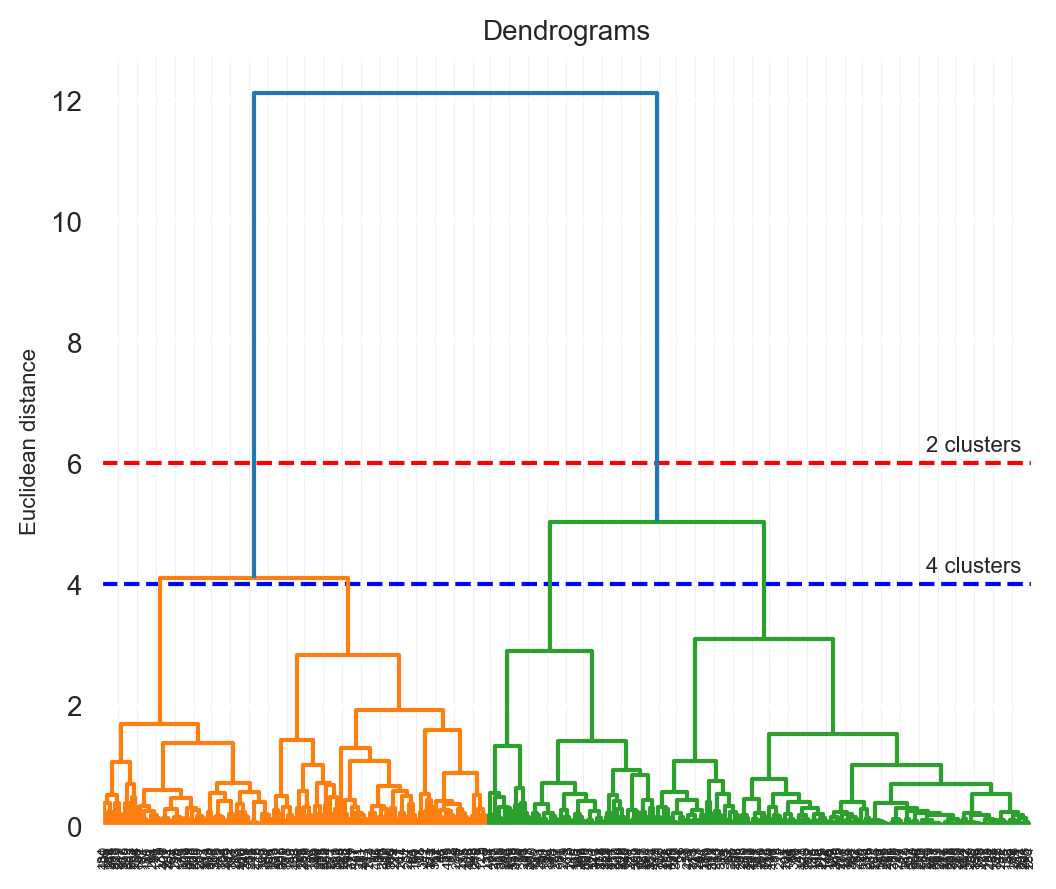

In [478]:
plt.figure(figsize=(6, 5))  
plt.title("Dendrograms", fontsize=10)
plt.ylabel('Euclidean distance', fontsize=8)
plt.axhline(y=6, color='r', linestyle='--')
plt.axhline(y=4, color='b', linestyle='--')
plt.text(3900, 6.2, '2 clusters', fontsize=8)
plt.text(3900, 4.2, '4 clusters', fontsize=8)
dend = shc.dendrogram(shc.linkage(grocery_scaled, method='ward'))

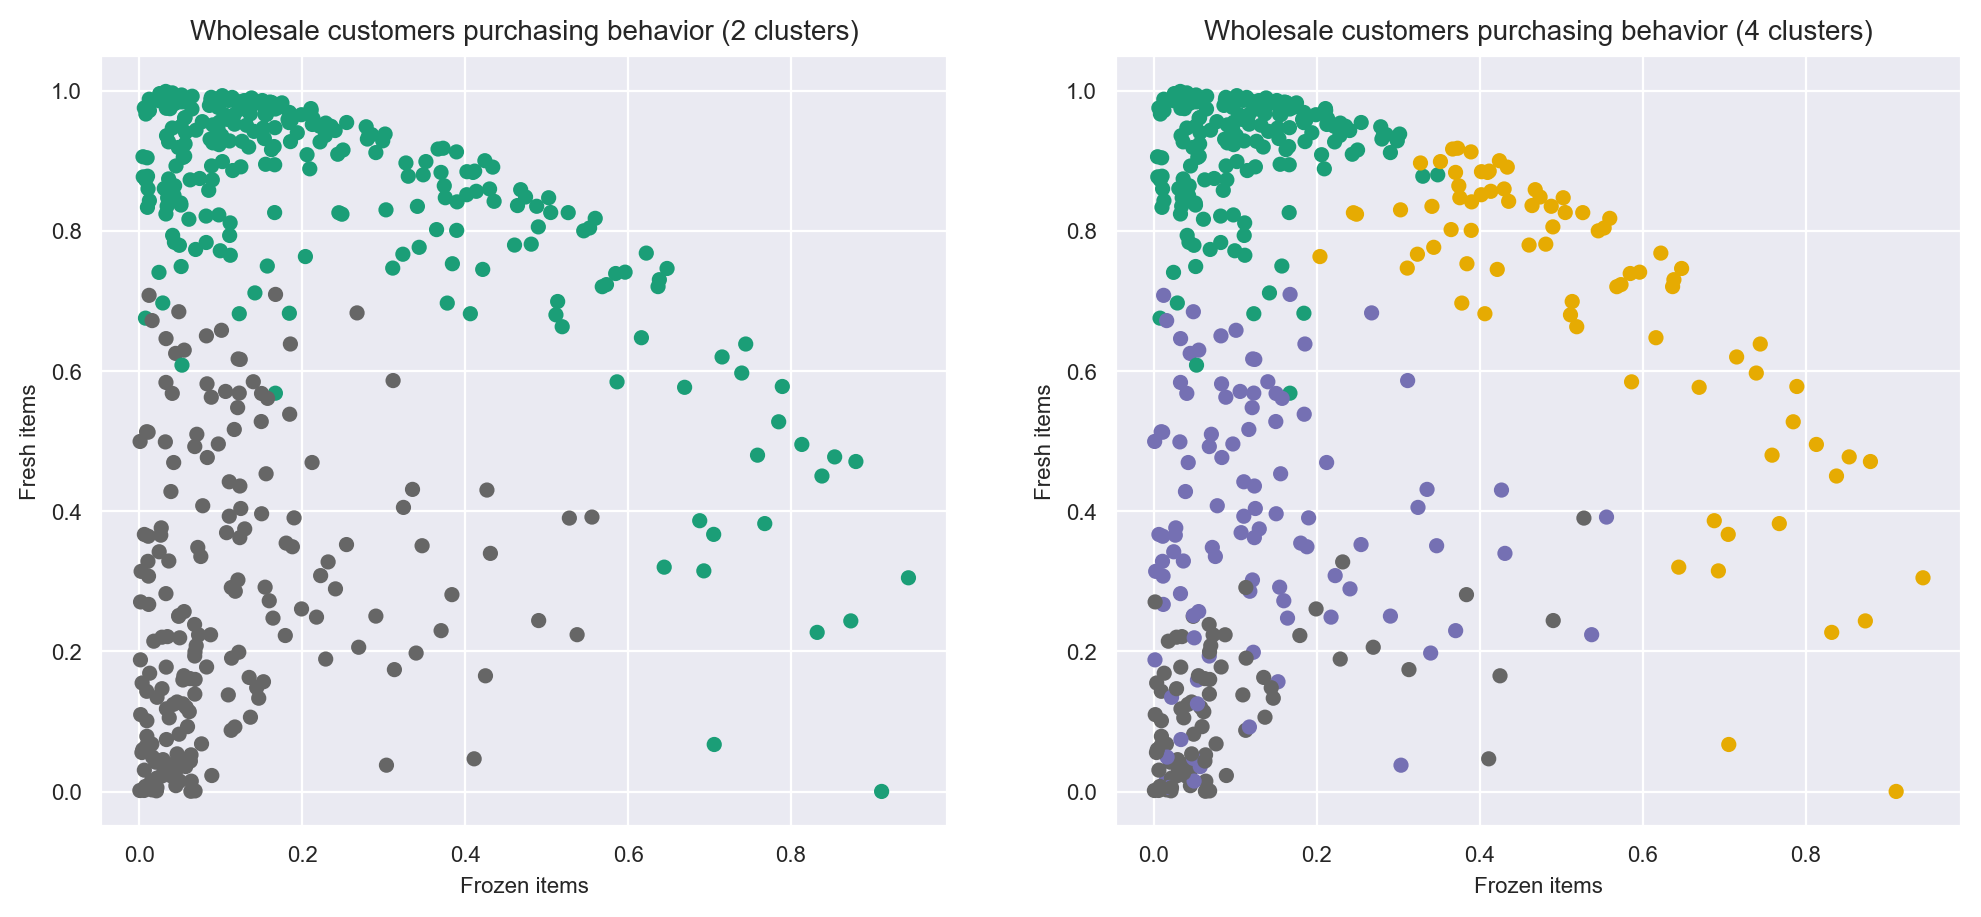

In [499]:
cluster2 = AgglomerativeClustering(n_clusters=2,
                                   affinity='euclidean',
                                   linkage='ward')  
cluster2.fit(grocery_scaled)
cluster4 = AgglomerativeClustering(n_clusters=4,
                                   affinity='euclidean',
                                   linkage='ward')  
cluster4.fit(grocery_scaled)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title('Wholesale customers purchasing behavior (2 clusters)',
                fontsize=10)
ax[0].set_ylabel('Fresh items', fontsize=8)
ax[0].set_xlabel('Frozen items', fontsize=8)
ax[0].tick_params(labelsize=8)
ax[0].scatter(grocery_scaled['Frozen'], grocery_scaled['Fresh'],
              s=20, c=cluster2.labels_, cmap='Dark2')
ax[1].set_title('Wholesale customers purchasing behavior (4 clusters)',
                fontsize=10)
ax[1].set_ylabel('Fresh items', fontsize=8)
ax[1].set_xlabel('Frozen items', fontsize=8)
ax[1].tick_params(labelsize=8)
ax[1].scatter(grocery_scaled['Frozen'], grocery_scaled['Fresh'],
              s=20, c=cluster4.labels_, cmap='Dark2')
plt.show()

From these plots, we can see the hierarchical clustering in action. Now we can clearly observe the relationship of the data in the clusters we defined. This information will be very helpful when designing new marketing campaigns targeted at these customers. 

### 3. What about their time complexities?

Every algorithm will have their own unique time and space complexities. In this article, we will discuss the time complexity of the various clustering algorithms we have exhibited. In sequence of rising time complexity, we have:

1. K-means $O(n)$
2. K-means++ $O(n)$
3. Spectral clustering $O(n^3)$
4. Hierarchical clustering $O(n^3)$

While the standard K-means algorithms have better time complexities in the group, it is worth noting that the problems that they solve may not be adequate to more exotic problems. Consider the circular data problem we discussed earlier. In that case, the Spectral clustering excels in solving those type of problem but at a heavy computational cost. For the case of Spectral clustering, this to the time taken from solving the eigenvalues of a very large dataset. Let's run an experiemnt to determine this.

In [26]:
# Generate toy dataset
import time

# Test K-means
size = [100, 1000, 5000, 10000, 15000, 20000, 25000, 30000, 35000]
kmeans_diff = []
for test in size:
    x_train, true_labels = make_blobs(n_samples=test,
                                      cluster_std=0.65)
    t1 = time.perf_counter()
    km = KMeans(n_clusters=50)
    km.fit(x_train)
    t2=time.perf_counter()
    kmeans_diff.append(t2 - t1)

kmeanspp_diff = []
for test in size:
    x_train, true_labels = make_blobs(n_samples=test,
                                      cluster_std=0.65)
    t1 = time.perf_counter()
    km = KMeans(n_clusters=50, init='k-means++')
    km.fit(x_train)
    t2=time.perf_counter()
    kmeanspp_diff.append(t2 - t1)

spectral_diff = []
for test in size:
    x_train, true_labels = make_circles(n_samples=test,
                                        factor=0.65, noise=0.05)
    t1 = time.perf_counter()
    spectral = SpectralClustering(n_clusters=50,
                                  affinity ='nearest_neighbors')
    spectral.fit(x_train)
    t2=time.perf_counter()
    spectral_diff.append(t2 - t1)

hierarchy_diff = []
for test in size:
    x_train, true_labels = make_blobs(n_samples=test,
                                      cluster_std=0.65)
    t1 = time.perf_counter()
    hierarchy = AgglomerativeClustering(n_clusters=50,
                                        affinity='euclidean',
                                        linkage='ward')  
    hierarchy.fit(x_train)
    t2=time.perf_counter()
    hierarchy_diff.append(t2 - t1)

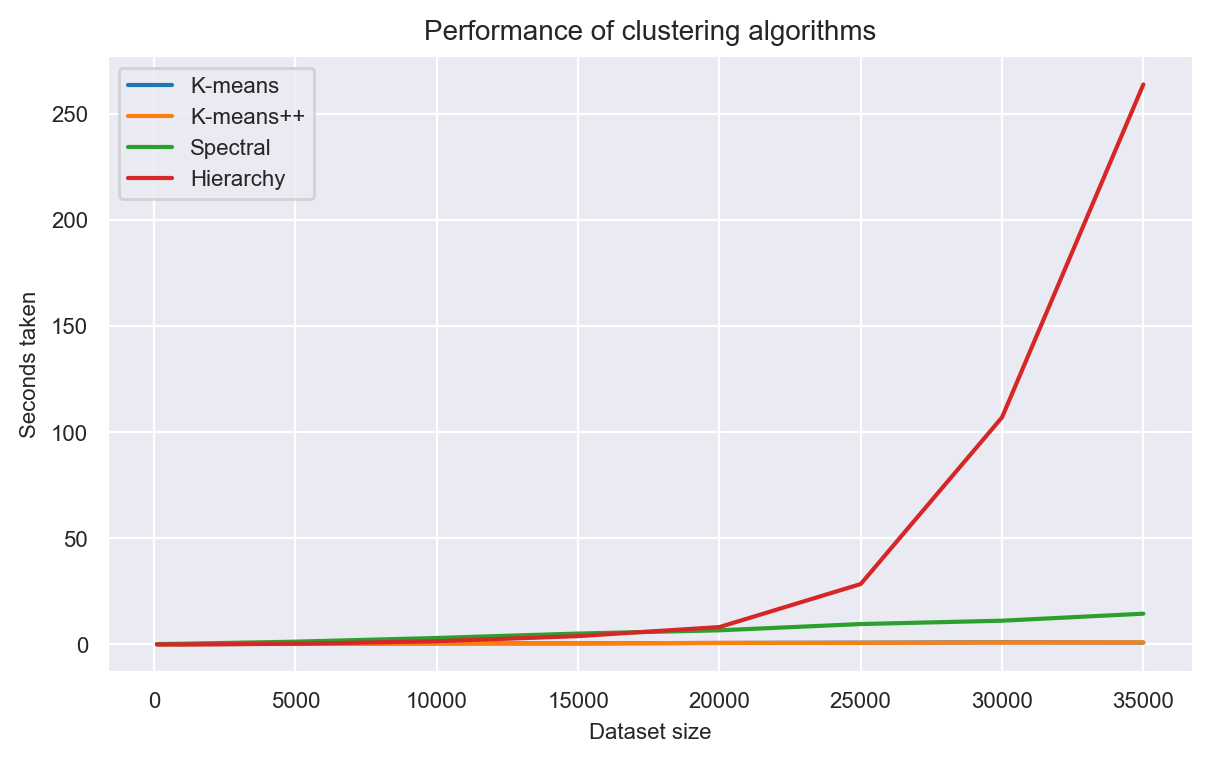

In [28]:
# Construct plots vs sample size to observe effects
plt.figure(figsize=(7, 4))
plt.plot(size, kmeans_diff, label='K-means')
plt.plot(size, kmeanspp_diff, label='K-means++')
plt.plot(size, spectral_diff, label='Spectral')
plt.plot(size, hierarchy_diff, label='Hierarchy')
plt.legend(fontsize=8)
plt.title('Performance of clustering algorithms', fontsize=10)
plt.tick_params(labelsize=8)
plt.ylabel('Seconds taken', fontsize=8)
plt.xlabel('Dataset size', fontsize=8)
plt.show()

The four clustering algorithms that is shown in this article were used to fit datasets with increasing size to estimate their performance. As can be seen, the standard K-means and K-means++ algorithm performed the best. Spectral clustering did not do too bad, but for hierachical clustering, the performance degraded significantly past 20,000 observations. This comes to no surprise due to its computation intensive algorithm to iteratively form new clusters from older clusters over the whole procedure. It is worth noting that each of these algorithm do have their merits and when applied to solve the right kind of problems effectively with perhaps some trade-off to processing time.

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

### 4. Other applications of K-means clustering - image compression

Besides using the K-means algorithm to cluster data into groups, the algorithm can also be used to solve image compression problems. The algorithm is able to group pixels with similar shades of colors into clusters, and subsequently the centroid or in this case the average pixel color values will be used in place of the original image.

Let's experiment with the K-means algorithm on the following grayscale image[9].

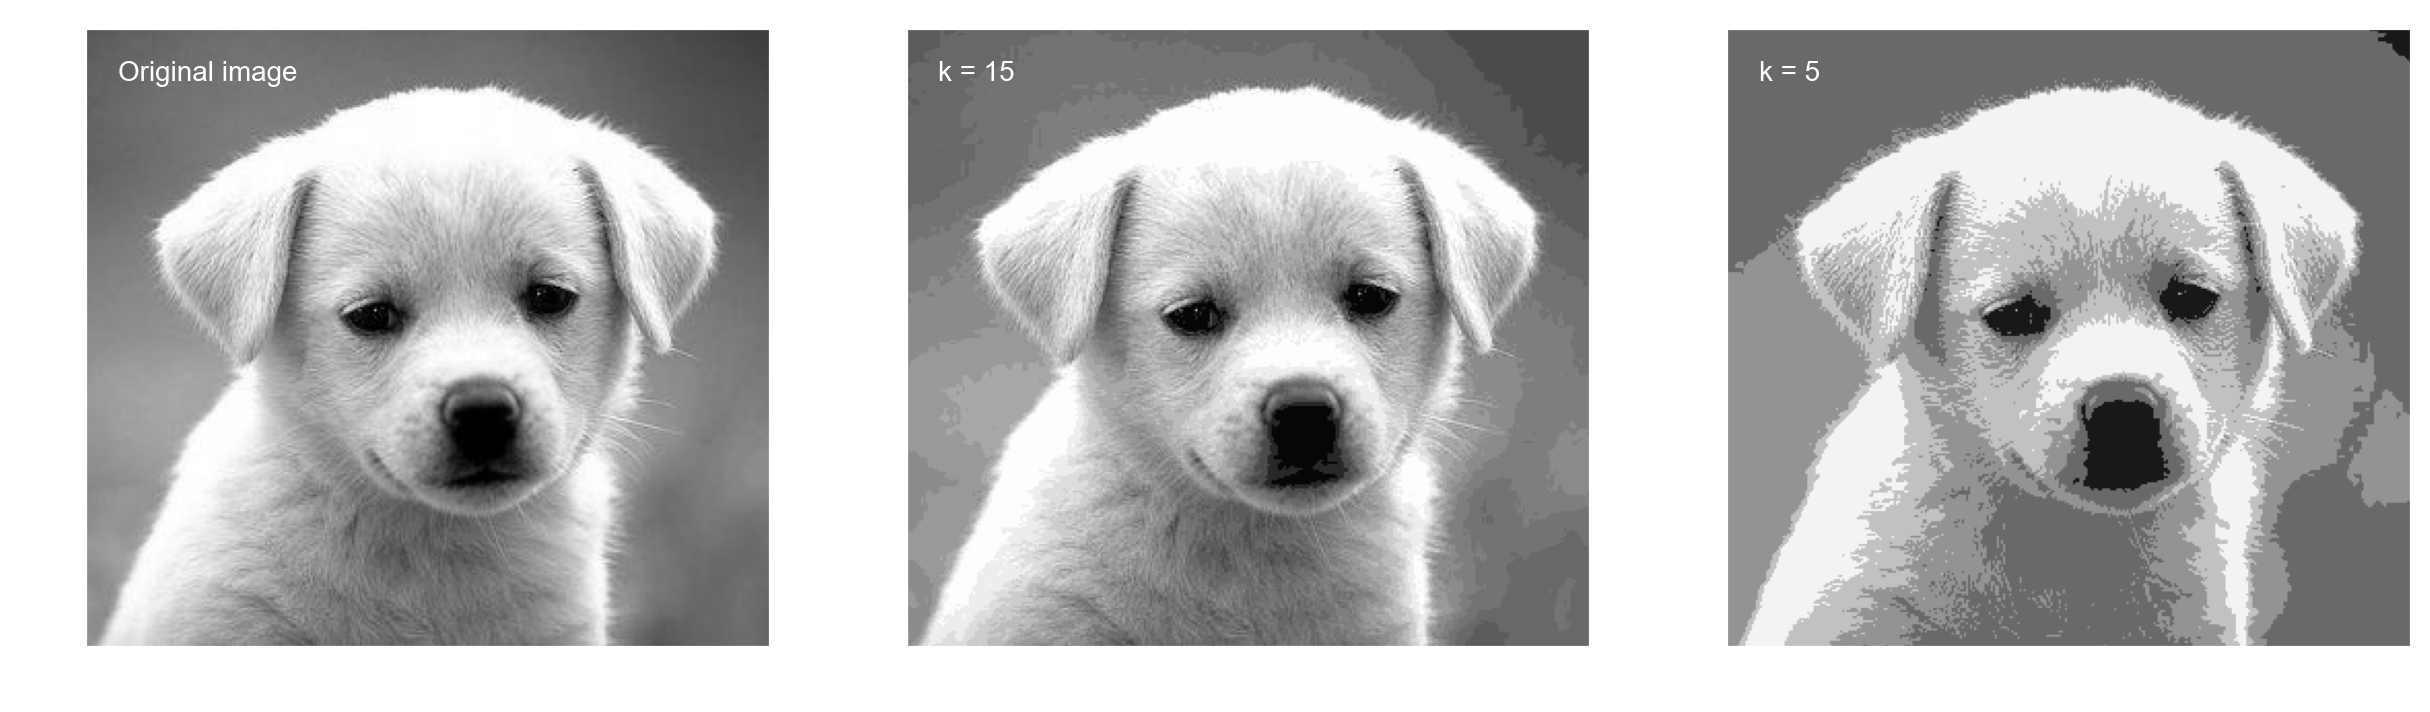

In [419]:
# Process the image to be used for compression
from PIL import Image
img = Image.open('B2DBy.jpg')
np.random.seed(0)
raw = img.getdata().convert('L')
raw = np.array(raw)
raw = raw.reshape((-1, 1))

w, h = img.size
img_dim = (h, w)

vmin = raw.min()
vmax = raw.max()

# Fit the Kmeans model to the data
kmeans5 = KMeans(n_clusters=5)
kmeans5.fit(raw)
values5 = kmeans5.cluster_centers_.squeeze()
labels5 = kmeans5.labels_

kmeans15 = KMeans(n_clusters=15)
kmeans15.fit(raw)
values15 = kmeans15.cluster_centers_.squeeze()
labels15 = kmeans15.labels_

img_comp5 = np.choose(labels5, values5)
img_comp5.shape = img_dim

img_comp15 = np.choose(labels15, values15)
img_comp15.shape = img_dim

# Plot the compressed image
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(img, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
axs[0].grid(False)
axs[0].text(15, 25, 'Original image', color='white', fontsize=10)
axs[0].tick_params(colors='white')
axs[1].imshow(img_comp15, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
axs[1].grid(False)
axs[1].tick_params(colors='white')
axs[1].text(15, 25, 'k = 15', color='white', fontsize=10)
axs[2].imshow(img_comp5, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
axs[2].grid(False)
axs[2].tick_params(colors='white')
axs[2].text(15, 25, 'k = 5', color='white', fontsize=10)
plt.show()

The images you see above show some examples of the degree of compression applied to the original image. The lower the cluster specified for the image, the more information is lost. However, this results in a smaller image file size. What about colored images? We can use K-means clustering to also compress colored images by strip color away from it. In the context of a colored image, each cluster represents the number of color available in the image. The following images[10] will give us some examples.

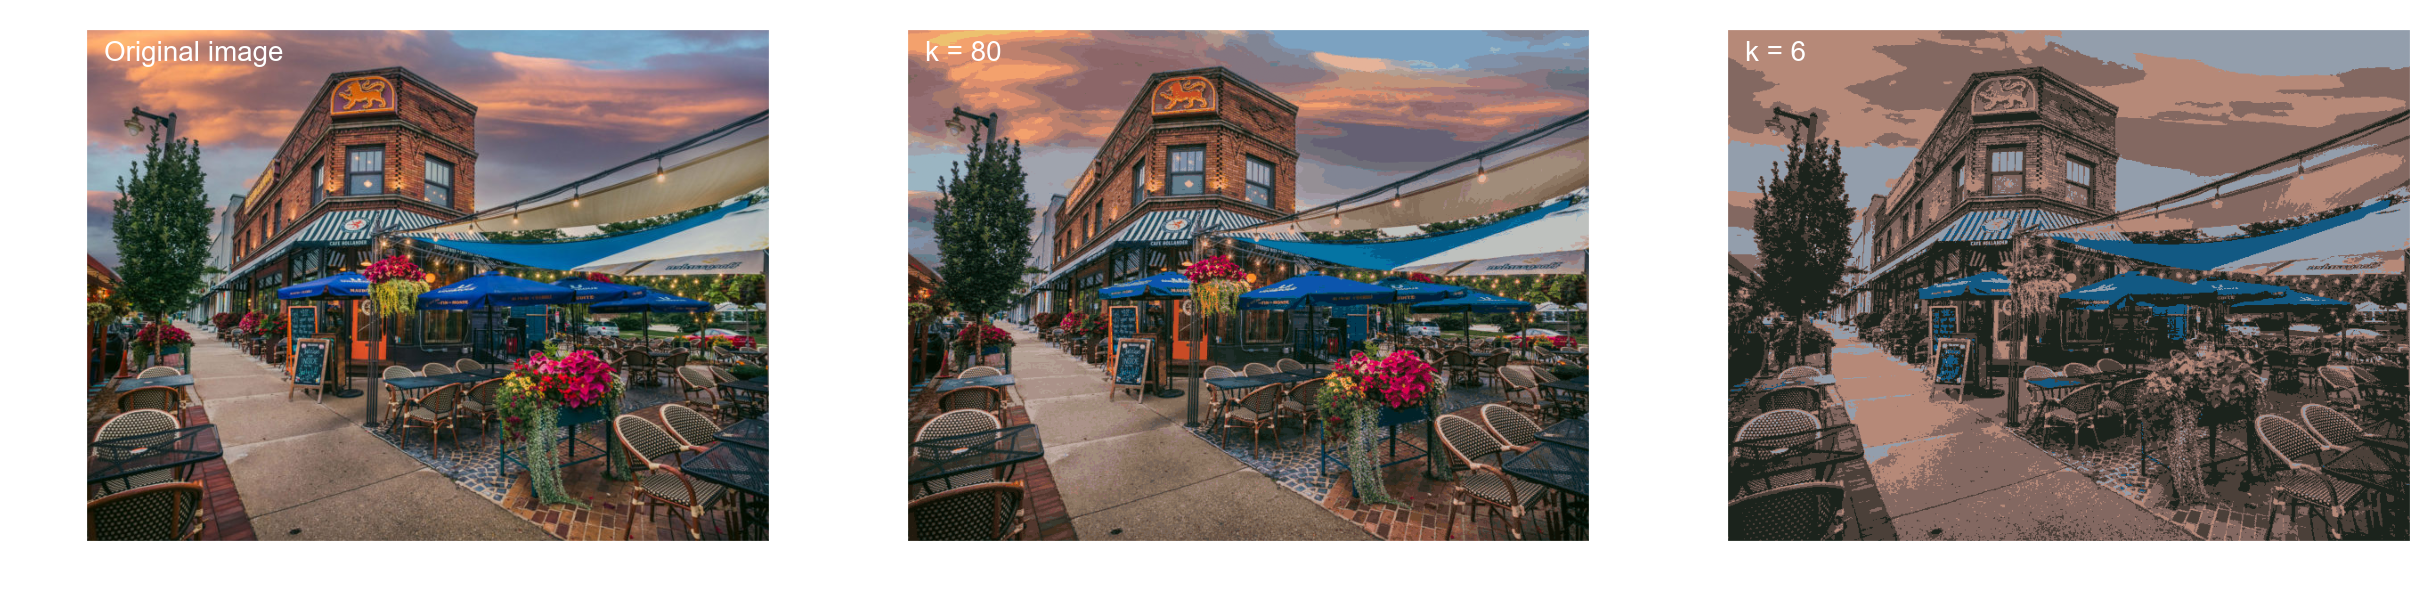

In [455]:
cafe = Image.open('cafe.jpg')
cafe = np.array(cafe, dtype=np.float64) / 255

w, h, d = original_shape = tuple(cafe.shape)

image_array = np.reshape(cafe, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0, n_samples=1000)
kmeans6 = KMeans(n_clusters=6).fit(image_array_sample)
kmeans80 = KMeans(n_clusters=80).fit(image_array_sample)

labels6 = kmeans6.predict(image_array)
labels80 = kmeans80.predict(image_array)
img_comp6 = kmeans6.cluster_centers_[labels6].reshape(w, h, -1)
img_comp80 = kmeans80.cluster_centers_[labels80].reshape(w, h, -1)

# Plot the compressed image
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(cafe, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
axs[0].grid(False)
axs[0].text(20, 35, 'Original image', color='white', fontsize=10)
axs[0].tick_params(colors='white')
axs[1].imshow(img_comp80)
axs[1].grid(False)
axs[1].tick_params(colors='white')
axs[1].text(20, 35, 'k = 80', color='white', fontsize=10)
axs[2].imshow(img_comp6)
axs[2].grid(False)
axs[2].tick_params(colors='white')
axs[2].text(20, 35, 'k = 6', color='white', fontsize=10)
plt.show()

Similar to the grayscale image from before, the lower the cluster or colors left in the image, the less information in the image is preserved but this comes at a tradeoff for a more compact image file size.

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

### 3. Summary

The K-means algorithm in general aims to group data into clusters based on Euclidean distance. It has many applications in the industry, from marketing, finance and much more. There are also many variants of the K-means algorithm. In this article, we discussed a few variants of the algorithm, which is K-means++, Spectral clustering and Hierarchical clustering. Like all machine learning algorithms, K-means also have hyperparameters that need to be tuned in order to train the best possible model. Two popular methods which is the Elbow method and Silhouette method is commonly used to find that optimum. With every algorithm, we need to understand their performance to understand better their cost to benefit when selecting them to solve a particular problem. There are low complexity clustering algorithms like K-Means and K-means++, and some more complex like Spectral clustering, and Hierarchical clustering being the worst in this article.

Beyond clustering data in the traditional sense, the K-means algorithm can also be employed in image processing as we have seen from some examples here. Overall, K-means is easy to understand and the simplicity in its algorithm makes this a very popular choice for unsupervised machine learning algorithm. I hope you have enjoyed reading this article as much as I have enjoyed crafting it for you. Thank you for reading!

### 4. References:
1. Wikipedia contributors 2023, "k-means clustering", Wikipedia, The Free Encyclopedia, accessed Feb 19, 2023, from <https://en.wikipedia.org/wiki/K-means_clustering>
2. Education Ecosystem 2018, "Understanding K-means Clustering in Machine Learning", Toward Data Science website, accessed Feb 19, 2023, from <https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1>
3. @savyakhosla 2021, "ML | K-means++ Algorithm", GeeksforGeeks website, accessed Feb 19, 2023, from <https://www.geeksforgeeks.org/ml-k-means-algorithm>
4. Gupta, Alind 2023, "Elbow Method for optimal value of k in KMeans", GeeksforGeeks website, accessed Feb 19, 2023, from <https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/>
5. Banerji, Ankita 2022, "K-Mean: Getting The Optimal Number Of Clusters", Analytics Vidhya website, accessed Feb 19, 2023, from <https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/#:~:text=The%20silhouette%20coefficient%20or%20silhouette,for%20each%20value%20of%20K.>
6. Saji, Basil 2022, "In-depth Intuition of K-Means Clustering Algorithm in Machine Learning", Analytics Vidhya website, accessed Feb 19, 2023, from <https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/>
7. Wikipedia contributors 2022, "Spectral clustering", Wikipedia, The Free Encyclopedia, accessed on Feb 20, 2023, from <https://en.wikipedia.org/wiki/Spectral_clustering>
8. Gandhi, Vipul 2020, "Spectral Clustering - Detailed Explanation", Kaggle website, accessed on Feb 20, 2023, from <https://www.kaggle.com/code/vipulgandhi/spectral-clustering-detailed-explanation>
9. qwr 2017, "Dither a Grayscale Image", Stack Exchange website, accessed on Feb 20, 2023, from <https://codegolf.stackexchange.com/questions/26554/dither-a-grayscale-image>
10. Lowlands Group, 2023, "Hollander Grand Cafe", Hollander Grand Cafe website, accessed on Feb 20, 2023, from <https://cafehollander.com/locations>
11. Wikipedia contributors 2023, "Hierarchical clustering", Wikiepedia, The Free Encyclopedia, accessed on Feb 25, 2023, from <https://en.wikipedia.org/wiki/Hierarchical_clustering>
12. @abhishekg25, "Difference between K means and Hierarchical Clustering", GeeksforGeeks website, accessed Feb 25, 2023, from <https://www.geeksforgeeks.org/difference-between-k-means-and-hierarchical-clustering/>
13. Sharma, Pulkit 2022, "A Beginner’s Guide to Hierarchical Clustering and how to Perform it in Python", Analytics Vidhya website, accessed Feb 25, 2023, from <https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/>
14. Chauhan, Nagesh Singh 2019, "What is Hierarchical Clustering?", KD Nuggets website, accessed Feb 25, 2023, from <https://www.kdnuggets.com/2019/09/hierarchical-clustering.html>